In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def runLayers(input_data, layers, sess):
    opt = input_data
    for i in range(len(layers)):
        encoder_op = layers[i]
        opt = sess.run(encoder_op['encoder'], feed_dict={encoder_op['x']: opt})
    return opt

In [25]:
def runDecodeLayers(layers):
    inputX = layers[0]['x']
    input = inputX
    for layer in layers:
        input = tf.nn.sigmoid(tf.add(tf.matmul(input, layer['weight']), layer['bias']))

    layers.reverse()

    output = input
    for layer in layers:
        output = tf.nn.sigmoid(tf.add(tf.matmul(output, layer['weightd']), layer['biasd']))
        
    layers.reverse()

    return output

In [26]:
def create_encoder(weight_e, bias_e, weight_d, bias_d, x):
    encoder = tf.nn.sigmoid(tf.add(tf.matmul(x, weight_e), bias_e))
    decoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder, weight_d), bias_d))

    return {
        'encoder': encoder,
        'weight': weight_e,
        'bias': bias_e,
        'decoder': decoder,
        'weightd': weight_d,
        'biasd': bias_d,
        'x': x
    }

In [27]:
def create_temp_encoder(x, input_size, output_size):
    weight = tf.Variable(tf.random_normal([input_size, output_size]))
    bias = tf.Variable(tf.random_normal([output_size]))

    weight2 = tf.Variable(tf.random_normal([output_size, input_size]))
    bias2 = tf.Variable(tf.random_normal([input_size]))

    return create_encoder(weight, bias, weight2, bias2, x)

In [28]:
def train_layer(training_epochs, batch_size, display_step, optimizer, cost, input_data, temp_encoder, layers):
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        total_batch = int(len(input_data) / batch_size)
        for epoch in range(training_epochs):
            count = 0
            cst = 0.0

            for i in range(total_batch):
                end = count + batch_size
                if end > len(input_data):
                    end = len(input_data)

                batch_xs = runLayers(input_data[count:end], layers, session)
                _, c = session.run([optimizer, cost], feed_dict={temp_encoder['x']: batch_xs})

                cst = cst + c
                count = end

            cst = cst / total_batch
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1),
                      "cost=", "{:.9f}".format(cst))

        print("Optimization Finished!")

        weight_e = tf.constant(session.run(temp_encoder['weight']))
        bias_e = tf.constant(session.run(temp_encoder['bias']))

        weight_d = tf.constant(session.run(temp_encoder['weightd']))
        bias_d = tf.constant(session.run(temp_encoder['biasd']))

    return create_encoder(weight_e, bias_e, weight_d, bias_d, temp_encoder['x'])

In [29]:
def train(learning_rate, training_epochs, batch_size, display_step, input_data, steps):
    
    input_size = len(input_data[1])
    
    layers = []
    
    for step in steps:

        X = tf.placeholder("float", [None, input_size])
        temp_encoder = create_temp_encoder(X, input_size, step)

        y_pred = temp_encoder['decoder']
        y_true = temp_encoder['x']

        cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
        
        layer = train_layer(training_epochs, batch_size, display_step, optimizer, cost, input_data, temp_encoder, layers)
        
        input_size = step
        
        layers.append(layer)

    return layers

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [31]:
layers = train(0.01, 40, 256, 1, mnist.train.images, [256, 128])

Epoch: 0001 cost= 0.368859453
Epoch: 0002 cost= 0.090811933
Epoch: 0003 cost= 0.066535809
Epoch: 0004 cost= 0.057058518
Epoch: 0005 cost= 0.051131285
Epoch: 0006 cost= 0.046603169
Epoch: 0007 cost= 0.041675039
Epoch: 0008 cost= 0.039590968
Epoch: 0009 cost= 0.038300041
Epoch: 0010 cost= 0.037059327
Epoch: 0011 cost= 0.036160153
Epoch: 0012 cost= 0.035106846
Epoch: 0013 cost= 0.034396415
Epoch: 0014 cost= 0.033595930
Epoch: 0015 cost= 0.033075167
Epoch: 0016 cost= 0.032674913
Epoch: 0017 cost= 0.032117797
Epoch: 0018 cost= 0.031683611
Epoch: 0019 cost= 0.031395762
Epoch: 0020 cost= 0.031113459
Epoch: 0021 cost= 0.030833628
Epoch: 0022 cost= 0.030479378
Epoch: 0023 cost= 0.030187653
Epoch: 0024 cost= 0.030019675
Epoch: 0025 cost= 0.029563989
Epoch: 0026 cost= 0.029289219
Epoch: 0027 cost= 0.028968170
Epoch: 0028 cost= 0.028788557
Epoch: 0029 cost= 0.028632380
Epoch: 0030 cost= 0.028520931
Epoch: 0031 cost= 0.028438616
Epoch: 0032 cost= 0.028309648
Epoch: 0033 cost= 0.028167013
Epoch: 003

In [32]:
examples_to_show = 10
inputX = layers[0]['x']

with tf.Session() as def_session:
    def_session.run(tf.global_variables_initializer())
    decoder = runDecodeLayers(layers)
    encode_decode = def_session.run(
        decoder, feed_dict={inputX: mnist.test.images[:examples_to_show]})

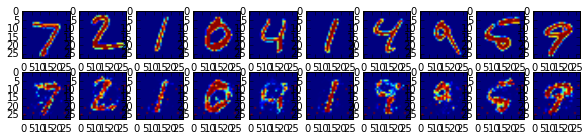

In [33]:
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))